# Evaluation of multi-omics GRN inference methods
## Benchmarking of the inferred GRNs
### by Jalil Nourisa



# Imports

In [1]:
# !pip install anndata lightgbm

In [2]:
# !conda install -c conda-forge graph-tool -y 

In [1]:
import os
import gzip
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn
import tqdm
import scipy
import json

os.environ['KMP_DUPLICATE_LIB_OK']='True'

work_dir = '../output'
resource_dir = '../resources'
os.makedirs(f'{work_dir}', exist_ok=True)

In [2]:
methods = ['Random',
 'CollectRI',
 'FigR',
 'CellOracle',
 'GRaNIE',
 'ANANSE',
 'scGLUE',
 'Scenic+',
 'HKG',
 'Positive',
 'Negative',
 'Positive Control',
 'Negative Control']

surragate_names = {'CollectRI': 'CollectRI', 'collectRI':'CollectRI', 'collectRI_sign':'CollectRI-signs',
                   'Scenic+': 'Scenic+', 'scenicplus':'Scenic+', 'scenicplus_sign': 'Scenic+-signs',
                   'CellOracle': 'CellOracle', 'celloracle':'CellOracle', 'celloracle_sign':'CellOracle-signs',
                   'figr':'FigR', 'figr_sign':'FigR-signs',
                   'baseline':'Baseline',
                   'cov_net': 'Pearson cov',
                   'granie':'GRaNIE',
                   'ananse':'ANANSE',
                   'scglue':'scGLUE',
                   
                   'positive_control':'Positive Control',
                   'negative_control':'Negative Control',
                   'pearson':'Pearson',
                   'SL':'SLA'
                   }

# COLORS = {
#     'Random': '#74ab8c',
#     'CollectRI': '#83b17b',
#     'FigR': '#96b577',
#     'CellOracle': '#b0b595',
#     'GRaNIE': '#c9b4b1',
#     'ANANSE': '#e2b1cd',
#     'scGLUE': '#e5b8dc',
#     'Scenic+': '#dfc2e5',
#     'HKG': '#e7d2ec',
#     'Positive': 'darkblue',
#     'Negative': 'indianred',
#     'Positive Control': 'darkblue',
#     'Negative Control': 'indianred'
# }

COLORS = {
    'Random': '#74ab8c',
    'CollectRI': '#83b17b',
    'FigR': '#56B4E9',
    'CellOracle': '#b0b595',
    'GRaNIE': '#009E73',
    'ANANSE': '#e2b1cd',
    'scGLUE': '#D55E00',
    'Scenic+': '#dfc2e5',
    'HKGs': 'darkblue',
    'Positive': 'darkblue',
    'Negative': 'indianred',
    'Positive Control': 'darkblue',
    'Negative Control': 'indianred'
}
LINESTYLES = {
    'Random': '-',
    'CollectRI': '--',
    'FigR': '-.',
    'CellOracle': ':',
    'GRaNIE': ':',
    'ANANSE': '--',
    'scGLUE': '-.',
    'Scenic+': '-',
}

In [3]:
controls3 = ['Dabrafenib', 'Belinostat', 'Dimethyl Sulfoxide']
control_compound = 'Dimethyl Sulfoxide'


def shuffle_grn(grn):
    grn_s = grn.copy()
    grn_s['source'] = grn_s['source'].sample(frac=1).reset_index(drop=True)
    grn_s['target'] = grn_s['target'].sample(frac=1).reset_index(drop=True)
    dup_flags = grn_s[['source','target']].duplicated()
    grn_s = grn_s[~dup_flags].reset_index(drop=True)
    if grn_s.duplicated().sum()>0:
        raise ValueError('')
    return grn_s
def sign_grn(grn):
    grn_sign = grn.copy()
    weights = grn_sign.weight
    weights = [1 if weight>0 else -1 for weight in weights]
    grn_sign.weight = weights
    return grn_sign


# housekeeping genes
if False:
    df = pd.read_csv('https://www.tau.ac.il/~elieis/HKG/HK_genes.txt', sep=' ', header=None)

    housekeeping_genes = df.loc[:, 0]  # Gene names
    housekeeping_genes = df_train.columns[df_train.columns.isin(housekeeping_genes)].values
    np.savetxt(f'{work_dir}/benchmark/housekeeping_genes.txt', housekeeping_genes, fmt='%s')
else:
    housekeeping_genes = np.loadtxt(f'{work_dir}/benchmark/housekeeping_genes.txt', dtype=str)

print(f'Number of housekeeping genes: {len(housekeeping_genes)}')

if False:
    collectRI = pd.read_csv("https://github.com/pablormier/omnipath-static/raw/main/op/collectri-26.09.2023.zip")
    collectRI.to_csv(f'{work_dir}/collectri.csv')


Number of housekeeping genes: 3804


In [318]:
grn_model_names = ['figr', 'celloracle', 'granie', 'scglue', 'scenicplus']

n_nets = len(grn_model_names)


grn_models_dict = {}
for name in grn_model_names:
    grn_models_dict[name] = pd.read_csv(f'../output/benchmark/grn_models/{name}.csv', index_col=0)

grn_models_dict = {surragate_names[name]:grn for name, grn in grn_models_dict.items()}

In [322]:
tfs_n_list = [grn.source.unique().shape[0] for grn in grn_models_dict.values()]
print(np.min(tfs_n_list), np.median(tfs_n_list), np.max(tfs_n_list))

140 389.0 557


# main run

In [ ]:

def plot_table(reg_type, exclude_missing_genes, manipulate, theta, tf_n):
    mat = []
    for i_plot, norm_method in enumerate(['pearson', 'lognorm', 'seurat_pearson', 'seurat_lognorm', 'scgen_pearson', 'scgen_lognorm']):
    # for i_plot, norm_method in enumerate(['scgen_pearson']):
        row = []
        # for grn_model in ['negative_control', 'collectRI', 'GRANIE', 'CellOracle', 'FigR', 'scGLUE', 'scenicplus', 'positive_control']:
        for grn_model in ['negative_control', 'collectRI', 'granie', 'celloracle', 'figr', 'scglue', 'scenicplus', 'positive_control']:
            file = f'{format_folder(work_dir, exclude_missing_genes, reg_type, theta, tf_n, norm_method)}/{grn_model}_{manipulate}.json'
            if not os.path.exists(file):
                print(f'Missing file: {file}')
                mean_score = np.nan
            else:
                with open(file, 'r') as f:
                    data = json.load(f)
                mean_score = data['mean_score_r2']
            row.append(mean_score)
        mat.append(row)
    mat = np.asarray(mat)

    print(mat)

    plt.figure(figsize=(8, 5))
    ax = plt.subplot(1, 1, 1)
    xticklabels = ['Negative control', 'collectRI', 'GRANIE', 'CellOracle', 'FigR', 'scGLUE', 'Scenic+', 'Positive control']
    yticklabels = ['pearson', 'lognorm', 'seurat_pearson', 'seurat_lognorm', 'scgen_pearson', 'scgen_lognorm']
    seaborn.heatmap(mat, ax=ax, square=True, cbar=False, xticklabels=xticklabels, yticklabels=yticklabels, annot=True, fmt='.3f')
    plt.tight_layout()

## Default run

In [352]:
# EXPERIMENT: default 
experiment = 'default'
reg_type = 'ridge'
!python regression.py --experiment {experiment} --reg_type {reg_type} --force

experiment='default',exclude_missing_genes=False,force=True, manipulate=None
reg_type='ridge', norm_method='pearson', model_name='negative_control', exclude_missing_genes=False
(15215, 400) (15215, 200)
score_r2:  -0.016367912136892926 loss_mse:  0.1938927607642767
../output/benchmark/scores/exclude_missing_genes_False/ridge/theta_1.0_tf_n_None/pearson/negative_control_None.json
reg_type='ridge', norm_method='lognorm', model_name='negative_control', exclude_missing_genes=False
(15215, 400) (15215, 200)
score_r2:  -0.017203451145185737 loss_mse:  1.010754004577529
../output/benchmark/scores/exclude_missing_genes_False/ridge/theta_1.0_tf_n_None/lognorm/negative_control_None.json
reg_type='ridge', norm_method='scgen_pearson', model_name='negative_control', exclude_missing_genes=False
(15215, 400) (15215, 200)
score_r2:  -0.0173147415934752 loss_mse:  0.16428173
../output/benchmark/scores/exclude_missing_genes_False/ridge/theta_1.0_tf_n_None/scgen_pearson/negative_control_None.json
reg_typ

[[-0.01636791  0.0178293   0.0388316   0.03023375  0.07751652  0.15555769
   0.18508843  0.4133917 ]
 [-0.01720345  0.00514996  0.03685016  0.00811027  0.06495265  0.07757599
   0.07720532  0.86837947]
 [-0.0168611   0.01968595  0.04278034  0.03018583  0.08428682  0.1667767
   0.19871259  0.40100392]
 [-0.01581932  0.00602754  0.041933    0.00873705  0.07448169  0.09012985
   0.09101237  0.84416312]
 [-0.01731474  0.02424059  0.04617858  0.0325468   0.09363965  0.18586535
   0.22661591  0.29465482]
 [-0.01645906  0.01372226  0.07727727  0.01804292  0.14161796  0.16984069
   0.17377826  0.88271717]]


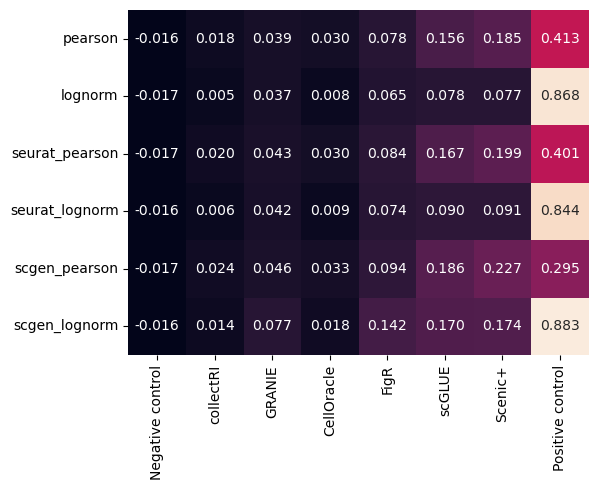

In [353]:
from regression import format_folder
reg_type = 'ridge'
exclude_missing_genes = False 
manipulate=None

theta = 1.0
tf_n = None

plot_table(reg_type, exclude_missing_genes, manipulate, theta, tf_n)
# plt.savefig('../output/benchmark/figs/first-validation-heatmap.png', dpi=300, transparent=True)

## default run + exclude missing genes

In [346]:
experiment = 'default'
reg_type = 'ridge'
!python regression.py --experiment {experiment} --reg_type {reg_type} --force --exclude-missing-genes

experiment='default',exclude_missing_genes=True,force=True, manipulate=None
reg_type='ridge', norm_method='pearson', model_name='negative_control', exclude_missing_genes=True
(15215, 400) (15215, 200)
score_r2:  -0.016612762329225175 loss_mse:  0.1865864117021554
../output/benchmark/scores/exclude_missing_genes_True/ridge/theta_1.0_tf_n_None/pearson/negative_control_None.json
reg_type='ridge', norm_method='lognorm', model_name='negative_control', exclude_missing_genes=True
(15215, 400) (15215, 200)
score_r2:  -0.017152455995812013 loss_mse:  0.9809621829288845
../output/benchmark/scores/exclude_missing_genes_True/ridge/theta_1.0_tf_n_None/lognorm/negative_control_None.json
reg_type='ridge', norm_method='scgen_pearson', model_name='negative_control', exclude_missing_genes=True
(15215, 400) (15215, 200)
score_r2:  -0.017464496154509918 loss_mse:  0.15386525
../output/benchmark/scores/exclude_missing_genes_True/ridge/theta_1.0_tf_n_None/scgen_pearson/negative_control_None.json
reg_type='r

[[-0.01661276  0.02690081  0.07498287  0.03617723  0.12484842  0.17006182
   0.25095542  0.39692495]
 [-0.01715246  0.00669856  0.09729253  0.00773771  0.1599486   0.14316874
   0.12066095  0.8398158 ]
 [-0.01705447  0.02521534  0.08090883  0.03543661  0.13610231  0.17962833
   0.26425362  0.40432617]
 [-0.01574987  0.00783531  0.10988272  0.00859597  0.17712216  0.16321669
   0.13696312  0.83401489]
 [-0.0174645   0.02895978  0.09035738  0.0382358   0.15490194  0.20742697
   0.30815003  0.29480676]
 [-0.0161571   0.01514223  0.17581662  0.01390899  0.28408184  0.25521118
   0.23224447  0.87888821]]


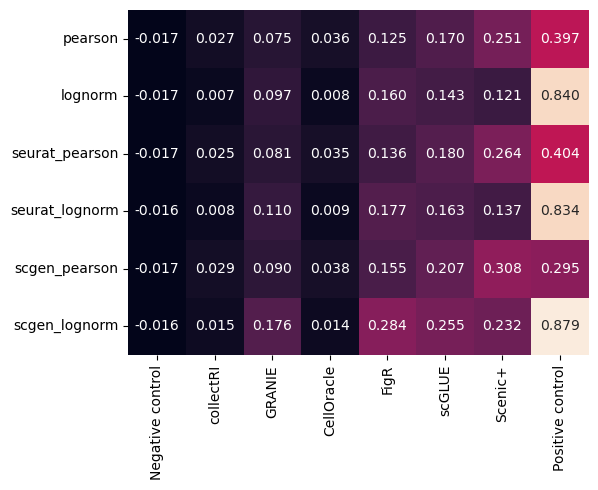

In [348]:
reg_type = 'ridge'
exclude_missing_genes = True 
manipulate=None

theta = 1.0
tf_n = None

plot_table(reg_type, exclude_missing_genes, manipulate, theta, tf_n)

## Mean scores of exclude and default

## Sign default

In [358]:
# EXPERIMENT: default 
experiment = 'default'
reg_type = 'ridge'
manipulate = 'signed'
!python regression.py --experiment {experiment} --reg_type {reg_type} --manipulate {manipulate} --force

experiment='default',exclude_missing_genes=False,force=True, manipulate='signed'
reg_type='ridge', norm_method='pearson', model_name='negative_control', exclude_missing_genes=False
(15215, 400) (15215, 200)
score_r2:  -0.016367912136892926 loss_mse:  0.1938927607642767
../output/benchmark/scores/exclude_missing_genes_False/ridge/theta_1.0_tf_n_None/pearson/negative_control_signed.json
reg_type='ridge', norm_method='lognorm', model_name='negative_control', exclude_missing_genes=False
(15215, 400) (15215, 200)
score_r2:  -0.017203451145185737 loss_mse:  1.010754004577529
../output/benchmark/scores/exclude_missing_genes_False/ridge/theta_1.0_tf_n_None/lognorm/negative_control_signed.json
reg_type='ridge', norm_method='scgen_pearson', model_name='negative_control', exclude_missing_genes=False
(15215, 400) (15215, 200)
score_r2:  -0.0173147415934752 loss_mse:  0.16428173
../output/benchmark/scores/exclude_missing_genes_False/ridge/theta_1.0_tf_n_None/scgen_pearson/negative_control_signed.js

[[-0.01636791  0.0178293   0.0439036   0.23379257  0.07765709  0.19815969
   0.16032333  0.38881402]
 [-0.01720345  0.00514996  0.04250681  0.06090479  0.06496347  0.10668289
   0.09815565  0.71611659]
 [-0.0168611   0.01968595  0.04735804  0.23872984  0.08448741  0.21096439
   0.17214669  0.37870165]
 [-0.01581932  0.00602754  0.04790993  0.0704945   0.07438604  0.12324665
   0.11452757  0.68963342]
 [-0.01731474  0.02424059  0.05207178  0.27761642  0.09365135  0.23587843
   0.19588084  0.33007122]
 [-0.01645906  0.01372226  0.08974608  0.13571944  0.14043583  0.23239185
   0.21774453  0.82853885]]


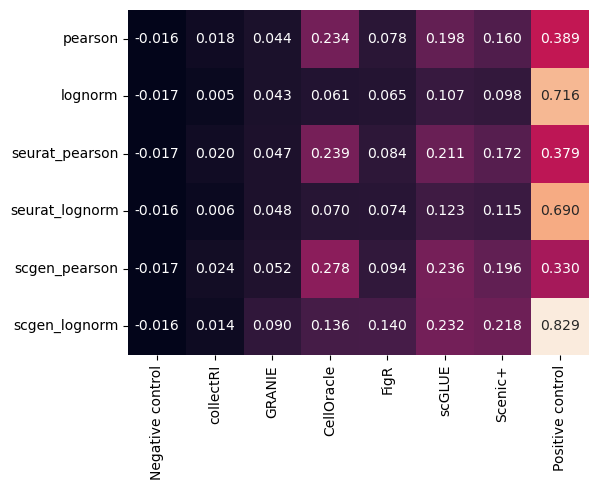

In [359]:
reg_type = 'ridge'
exclude_missing_genes = False 
manipulate='signed'

theta = 1.0
tf_n = None

plot_table(reg_type, exclude_missing_genes, manipulate, theta, tf_n)

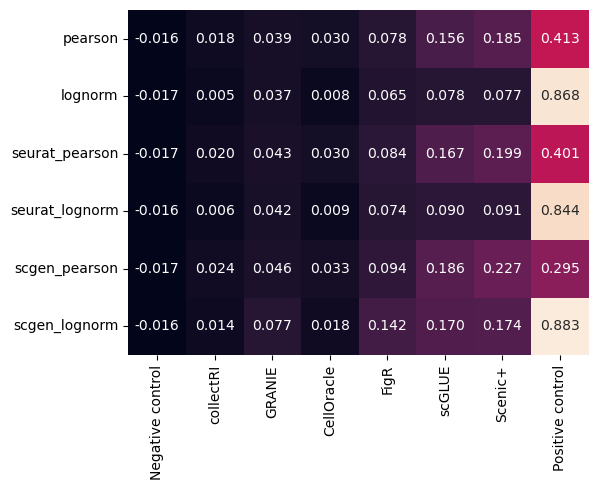

## Experiment with thetas

In [331]:
# EXPERIMENT: different thetas
experiment='theta'
!python regression.py --experiment {experiment}

experiment='theta',exclude_missing_genes=False,force=False, manipulate=None
reg_type='ridge', norm_method='pearson', model_name='negative_control', exclude_missing_genes=False
(15215, 1) (15215, 200)
score_r2:  -0.00020318821064960638 loss_mse:  0.1835746419646494
../output/benchmark/scores/exclude_missing_genes_False/ridge/theta_0.0_tf_n_None/pearson/negative_control_None.json
reg_type='ridge', norm_method='lognorm', model_name='negative_control', exclude_missing_genes=False
(15215, 1) (15215, 200)
score_r2:  -0.000299543766000735 loss_mse:  0.9647088971286951
../output/benchmark/scores/exclude_missing_genes_False/ridge/theta_0.0_tf_n_None/lognorm/negative_control_None.json
reg_type='ridge', norm_method='scgen_pearson', model_name='negative_control', exclude_missing_genes=False
(15215, 1) (15215, 200)
score_r2:  -0.00020779499737459616 loss_mse:  0.15125553
../output/benchmark/scores/exclude_missing_genes_False/ridge/theta_0.0_tf_n_None/scgen_pearson/negative_control_None.json
reg_typ

In [335]:
# EXPERIMENT: different tfs_n
experiment='tf_n'
!python regression.py --experiment {experiment}

experiment='tf_n',exclude_missing_genes=False,force=False, manipulate=None
reg_type='ridge', norm_method='pearson', model_name='negative_control', exclude_missing_genes=False
(15215, 140) (15215, 200)
score_r2:  -0.0060641081351021685 loss_mse:  0.1846503396722718
../output/benchmark/scores/exclude_missing_genes_False/ridge/theta_1_tf_n_140/pearson/negative_control_None.json
reg_type='ridge', norm_method='lognorm', model_name='negative_control', exclude_missing_genes=False
(15215, 140) (15215, 200)
score_r2:  -0.0064092322182042515 loss_mse:  0.970601202933749
../output/benchmark/scores/exclude_missing_genes_False/ridge/theta_1_tf_n_140/lognorm/negative_control_None.json
reg_type='ridge', norm_method='scgen_pearson', model_name='negative_control', exclude_missing_genes=False
Skip running because file exists:  ../output/benchmark/scores/exclude_missing_genes_False/ridge/theta_1_tf_n_140/scgen_pearson/negative_control_None.json
reg_type='ridge', norm_method='scgen_lognorm', model_name='n

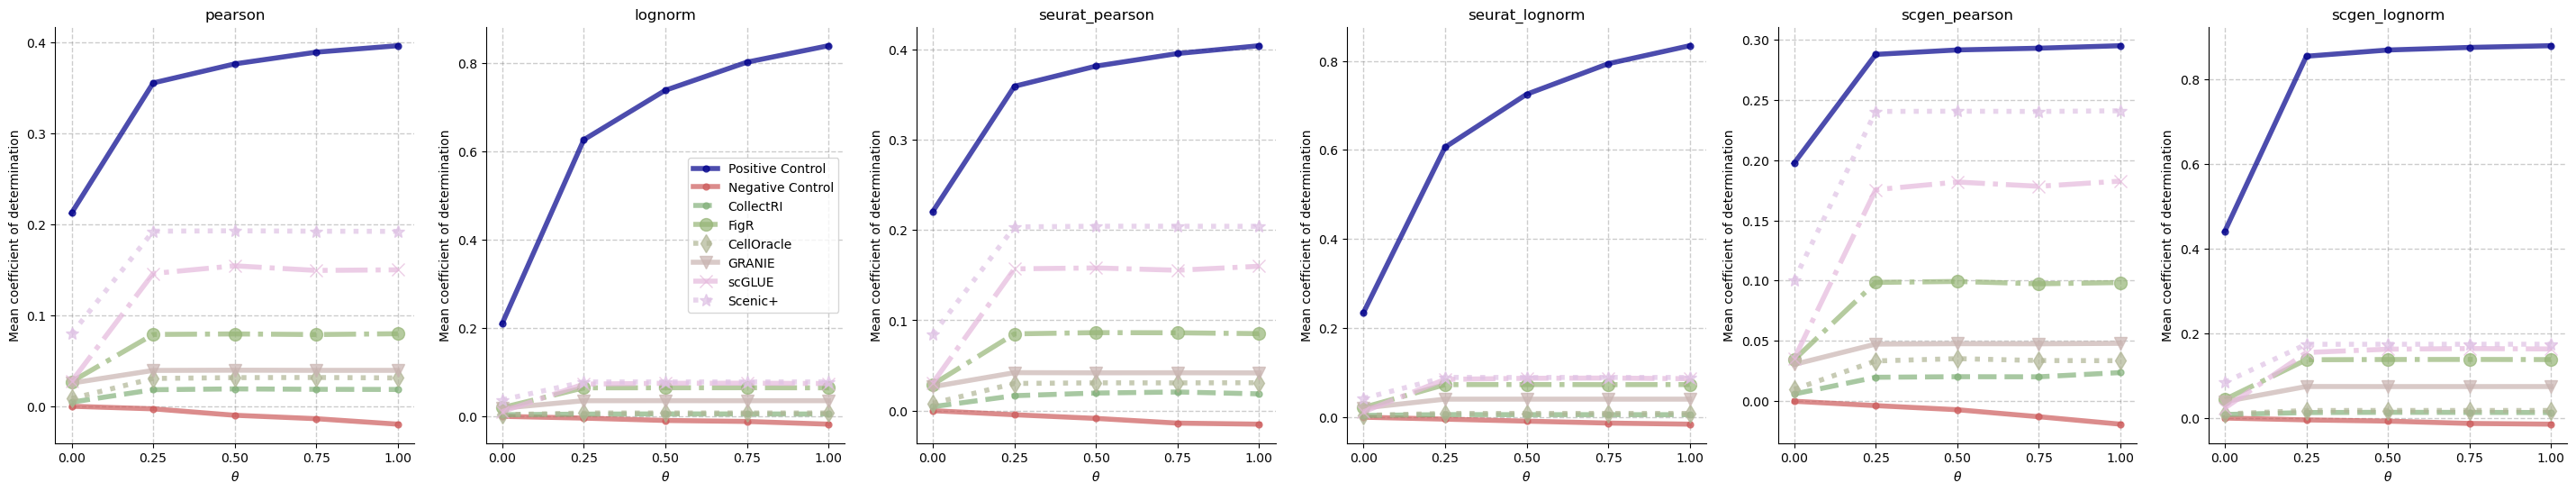

In [334]:
# experiment with theta
from regression import format_folder

# SORTED_METHODS = ['positive_control', 'negative_control', 'collectRI', 'FigR', 'CellOracle', 'GRANIE', 'ANANSE', 'scGLUE', 'scenicplus']
SORTED_METHODS = ['positive_control', 'negative_control', 'collectRI', 'figr', 'celloracle', 'granie', 'scglue', 'scenicplus']
NORM_METHODS = ['pearson', 'lognorm', 'seurat_pearson', 'seurat_lognorm', 'scgen_pearson', 'scgen_lognorm']
reg_type = 'ridge'
tf_n = None

work_dir, exclude_missing_genes, reg_type, theta, tf_n

surrogate_names = {
    'CollectRI': 'CollectRI', 'collectRI':'CollectRI', 'collectRI_sign':'CollectRI-signs',
    'Scenic+': 'Scenic+', 'scenicplus':'Scenic+', 'scenicplus_sign': 'Scenic+-signs',
    'CellOracle': 'CellOracle', 'celloracle':'CellOracle', 'celloracle_sign':'CellOracle-signs',
    'FigR': 'FigR', 'figr':'FigR', 'figr_sign':'FigR-signs',
    'baseline':'Baseline',
    'cov_net': 'Pearson cov',
    'GRANIE': 'GRANIE', 'granie':'GRANIE',
    'ANANSE': 'ANANSE', 'ananse':'ANANSE',
    'scGLUE': 'scGLUE', 'scglue':'scGLUE',
    'HKG': 'HKG', 'HKGs':'HKG',
    'positive-control': 'Positive Control', 'positive_control': 'Positive Control',
    'negative-control': 'Negative Control', 'negative_control':'Negative Control',
    'pearson':'Pearson',
    'SL':'SLA'
}

COLORS = {
    'Random': '#74ab8c',
    'CollectRI': '#83b17b',
    'FigR': '#96b577',
    'CellOracle': '#b0b595',
    'GRANIE': '#c9b4b1',
    'ANANSE': '#e2b1cd',
    'scGLUE': '#e5b8dc',
    'Scenic+': '#dfc2e5',
    'HKG': '#e7d2ec',
    'Positive': 'darkblue',
    'Negative': 'indianred',
    'Positive Control': 'darkblue',
    'Negative Control': 'indianred'
}

LINESTYLES = {
    'Random': '-',
    'CollectRI': '--',
    'FigR': '-.',
    'CellOracle': ':',
    'GRANIE': '-',
    'ANANSE': '--',
    'scGLUE': '-.',
    'Scenic+': ':',
    'Positive Control': '-',
    'Negative Control': '-'
}

MARKERS = {
    'Random': '.',
    'CollectRI': '.',
    'FigR': 'o',
    'CellOracle': 'd',
    'GRANIE': 'v',
    'ANANSE': 's',
    'scGLUE': 'x',
    'Scenic+': '*',
    'Positive Control': '.',
    'Negative Control': '.'
}

fig, axes = plt.subplots(1, len(NORM_METHODS), figsize=(6*len(NORM_METHODS), 6))

for k, norm_method,  in enumerate(NORM_METHODS):

    ax =axes[k]
    ax.grid(alpha=0.4, linewidth=1, color='grey', linestyle='--')
    xs = np.linspace(0, 1, 5)

    for method in SORTED_METHODS:

        series = []

        # for theta in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        for theta in np.linspace(0, 1, 5):
            # print(os.path.exists(f'{work_dir}/benchmark/scores/exclude_missing_genes_{exclude_missing_genes}/{estimator_t}/{theta}/'))
            # aa
            file =  f'{format_folder(work_dir, exclude_missing_genes, reg_type, theta, tf_n, norm_method)}/{method}_{manipulate}.json'
            if not os.path.exists(file):
                print(f'Missing file: {file}')
                mean_score = np.nan
            else:
                with open(file, 'r') as f:
                    data = json.load(f)
                mean_score = data['mean_score_r2']

            series.append(float(mean_score))
        
        ax.plot(
            xs, series, label=surrogate_names[method], color=COLORS[surrogate_names[method]], markersize=10,
            linestyle=LINESTYLES[surrogate_names[method]], marker=MARKERS[surrogate_names[method]], alpha=0.7, linewidth=4
        )

    ax.set_xticks(xs)
    ax.set_title(norm_method)
    # if k == 0:
        
    if k == 1:
        ax.legend()
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel('Mean coefficient of determination')
    #ax.set_ylim([0, 0.65])
# plt.savefig('../output/benchmark/figs/first-validation-performance-theta.png', dpi=300, transparent=True)
plt.show()